# Collaborative Filtering

Collaborative filtering is when we have information about how users have rated various items, such as movies, and we try to predict what rating a user would give a new movie they have yet to encounter.

Similar to tabular data, we store data for `collab` models in a `DataFrame`.

In [69]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## MovieLens Sample Dataset

In [2]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

The [MovieLens](https://grouplens.org/datasets/movielens/latest/) database simply contains ratings that various individuals have given various movies over time.

In [3]:
user,item,title = 'userId','movieId','title'

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


Storing ratings in the above way and indexing by timestamp keeps us from having to construct a massive sparse matrix that would take up a lot of memory (if we had a column for each movie in the db).

### Train a Simple Model

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

Max MovieLens rating is 5, and min rating is 0.5. Since we use a sigmoid activation function after the final layer of weights in order to keep predictions within this range, we need to choose a y-range that is just a bit wider than the max and min ratings values.

If we don't do this, our model will never be able to predict the max rating or min rating values for any users.

In [6]:
y_range = [0,5.5]

In [7]:
# n_factors is the embedding size for users & items.
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

Total time: 00:02
epoch  train_loss  valid_loss
1      1.602064    0.971312    (00:01)
2      0.846120    0.678361    (00:00)
3      0.645413    0.666974    (00:00)



## MovieLens 100K Dataset

Now we'll use the full, original MovieLens 100K dataset. It's available from: http://files.grouplens.org/datasets/movielens/ml-100k.zip.

This particular version of the MovieLens dataset is the one used by researchers so that they can compare results of their experiments.

In [24]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
download_url(url,dest=Config.data_path()/'ml-100k.zip')

In [31]:
! unzip ~/.fastai/data/ml-100k.zip -d ~/.fastai/data

Archive:  /home/jupyter/.fastai/data/ml-100k.zip
   creating: /home/jupyter/.fastai/data/ml-100k/
  inflating: /home/jupyter/.fastai/data/ml-100k/allbut.pl  
  inflating: /home/jupyter/.fastai/data/ml-100k/mku.sh  
  inflating: /home/jupyter/.fastai/data/ml-100k/README  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.data  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.genre  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.info  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.item  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.occupation  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.user  
  inflating: /home/jupyter/.fastai/data/ml-100k/u1.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u1.test  
  inflating: /home/jupyter/.fastai/data/ml-100k/u2.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u2.test  
  inflating: /home/jupyter/.fastai/data/ml-100k/u3.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u3.test  
  inflating: /home/jupyter/.fas

In [72]:
path = Config.data_path()/'ml-100k'

In [73]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [74]:
# Although it should be unicode nowadays, many of these old datasets'
# character encodings are 'latin-1'
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None,
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [75]:
len(ratings)

100000

In [76]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [77]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [78]:
data.show_batch()

userId,title,target
213,Father of the Bride Part II (1995),2.0
867,Stalker (1979),5.0
577,Hoop Dreams (1994),5.0
642,Gold Diggers: The Secret of Bear Mountain (1995),2.0
296,Sophie's Choice (1982),5.0
332,Kingpin (1996),4.0
501,Thinner (1996),3.0
919,Apt Pupil (1998),3.0


In [79]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


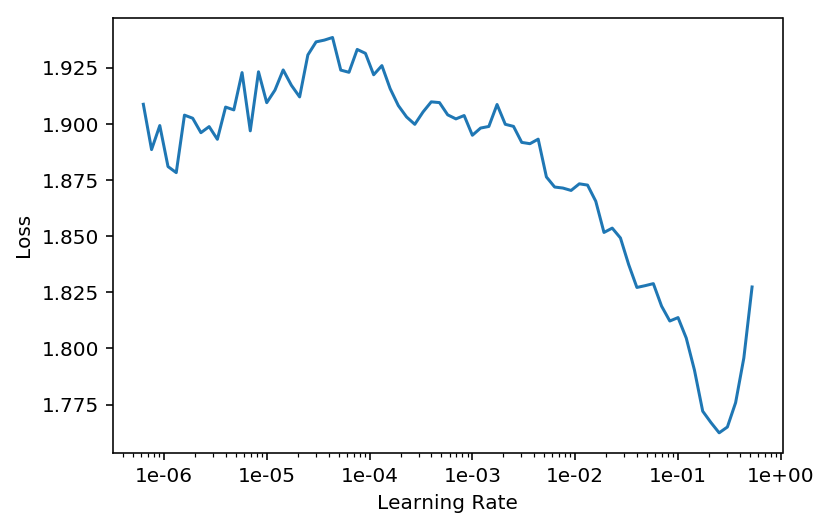

In [80]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [42]:
learn.fit_one_cycle(5, 5e-3)

Total time: 00:30
epoch  train_loss  valid_loss
1      0.941079    0.923412    (00:06)
2      0.813904    0.880893    (00:06)
3      0.768561    0.841144    (00:06)
4      0.651904    0.818509    (00:06)
5      0.581918    0.818927    (00:06)



In [43]:
learn.save('movielens100k-model')

Here are [benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset from when the popular Librec system for collab filtering was applied to it.

They show that the best results achieved a RMSE score of 0.91, which corresponds to an MSE score of `0.91**2 = 0.83`.

Our lowest validation loss (MSE) just above was `0.8185` after only four epochs!

## Interpretation

### Setup

In [45]:
learn.load('movielens100k-model');

In [46]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [47]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie Bias

In [48]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [49]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [50]:
item0 = lambda o: o[0]

Display the movies with the smallest biases, and then those with the highest biases.

In [51]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3536),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3210),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2947), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2794), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2569), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2560), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2465), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2460), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2405), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2286), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2219), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2215), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2207), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2170), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2065), 'Showgirls (1995)', 1.9

In [52]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.6183), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6060), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5802), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5477), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5454), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5363), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5327), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5021), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4989), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4908), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4819), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4736), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4656), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4594), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4511), 'Close Shave, A (1995)', 4.491071428571429)]

### Movie Weights

In [54]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [55]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [56]:
fac0, fac1, fac2 = movie_pca.t()

Use PCA to reduce the dimensions of embeddings to 3, and then display the movies with the highest weight along the first of the three PCA dimensions.

In [59]:
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1009), 'Casablanca (1942)'),
 (tensor(1.0821), 'Wrong Trousers, The (1993)'),
 (tensor(1.0752), 'Close Shave, A (1995)'),
 (tensor(1.0551), 'Chinatown (1974)'),
 (tensor(1.0362), 'When We Were Kings (1996)'),
 (tensor(1.0224), 'Lawrence of Arabia (1962)'),
 (tensor(1.0067), 'Godfather, The (1972)'),
 (tensor(0.9803), 'Ran (1985)'),
 (tensor(0.9799), 'Citizen Kane (1941)'),
 (tensor(0.9788), 'Persuasion (1995)')]

Then display the movies with the lowest weight along the same dimension.

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2996), "McHale's Navy (1997)"),
 (tensor(-1.2770), 'Home Alone 3 (1997)'),
 (tensor(-1.2664), 'Jungle2Jungle (1997)'),
 (tensor(-1.2242), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.2068), 'Bio-Dome (1996)'),
 (tensor(-1.1267), 'Batman & Robin (1997)'),
 (tensor(-1.1242), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1058), 'Congo (1995)'),
 (tensor(-1.0959), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0908), 'Grease 2 (1982)')]

Then do the same for the 2nd PCA dimension.

In [62]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [63]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8662), 'Keys to Tulsa (1997)'),
 (tensor(0.8536), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8266), 'Stupids, The (1996)'),
 (tensor(0.7959), 'Lost Highway (1997)'),
 (tensor(0.7687), 'Dracula: Dead and Loving It (1995)'),
 (tensor(0.7597), 'Spice World (1997)'),
 (tensor(0.7540), 'Trainspotting (1996)'),
 (tensor(0.7314), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7313), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7312), 'Dead Man (1995)')]

In [64]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1396), 'Braveheart (1995)'),
 (tensor(-1.0761), 'Titanic (1997)'),
 (tensor(-1.0523), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8770), "It's a Wonderful Life (1946)"),
 (tensor(-0.8673), 'American President, The (1995)'),
 (tensor(-0.8572), 'Pretty Woman (1990)'),
 (tensor(-0.8454), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8444), 'Forrest Gump (1994)'),
 (tensor(-0.8181), 'Air Force One (1997)'),
 (tensor(-0.8157), 'Sleepless in Seattle (1993)')]

Finally, do the same for the 3rd PCA dimension.

In [65]:
movie_comp = [(f, i) for f,i in zip(fac2, top_movies)]

In [66]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9613), 'Terminator, The (1984)'),
 (tensor(0.8688), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.8668), 'Reservoir Dogs (1992)'),
 (tensor(0.8667), 'Starship Troopers (1997)'),
 (tensor(0.8041), 'Scream (1996)'),
 (tensor(0.7554), 'Game, The (1997)'),
 (tensor(0.7388), 'Pulp Fiction (1994)'),
 (tensor(0.7356), 'Army of Darkness (1993)'),
 (tensor(0.7340), 'Clerks (1994)'),
 (tensor(0.7209), 'Seven (Se7en) (1995)')]

In [67]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.6628), 'Postman, The (1997)'),
 (tensor(-0.6493), 'Sound of Music, The (1965)'),
 (tensor(-0.6350), 'Lone Star (1996)'),
 (tensor(-0.6023), 'Steel (1997)'),
 (tensor(-0.6000), 'Crucible, The (1996)'),
 (tensor(-0.5944), 'My Fair Lady (1964)'),
 (tensor(-0.5938), 'To Kill a Mockingbird (1962)'),
 (tensor(-0.5814), 'Dirty Dancing (1987)'),
 (tensor(-0.5739), 'Gone with the Wind (1939)'),
 (tensor(-0.5632), 'All About Eve (1950)')]

Finally, we can plot the 3rd PCA dimension on the y-axis, and the 1st PCA dimension on the x-axis, to get a visual idea of the similarities and dissimilarities between the movies.

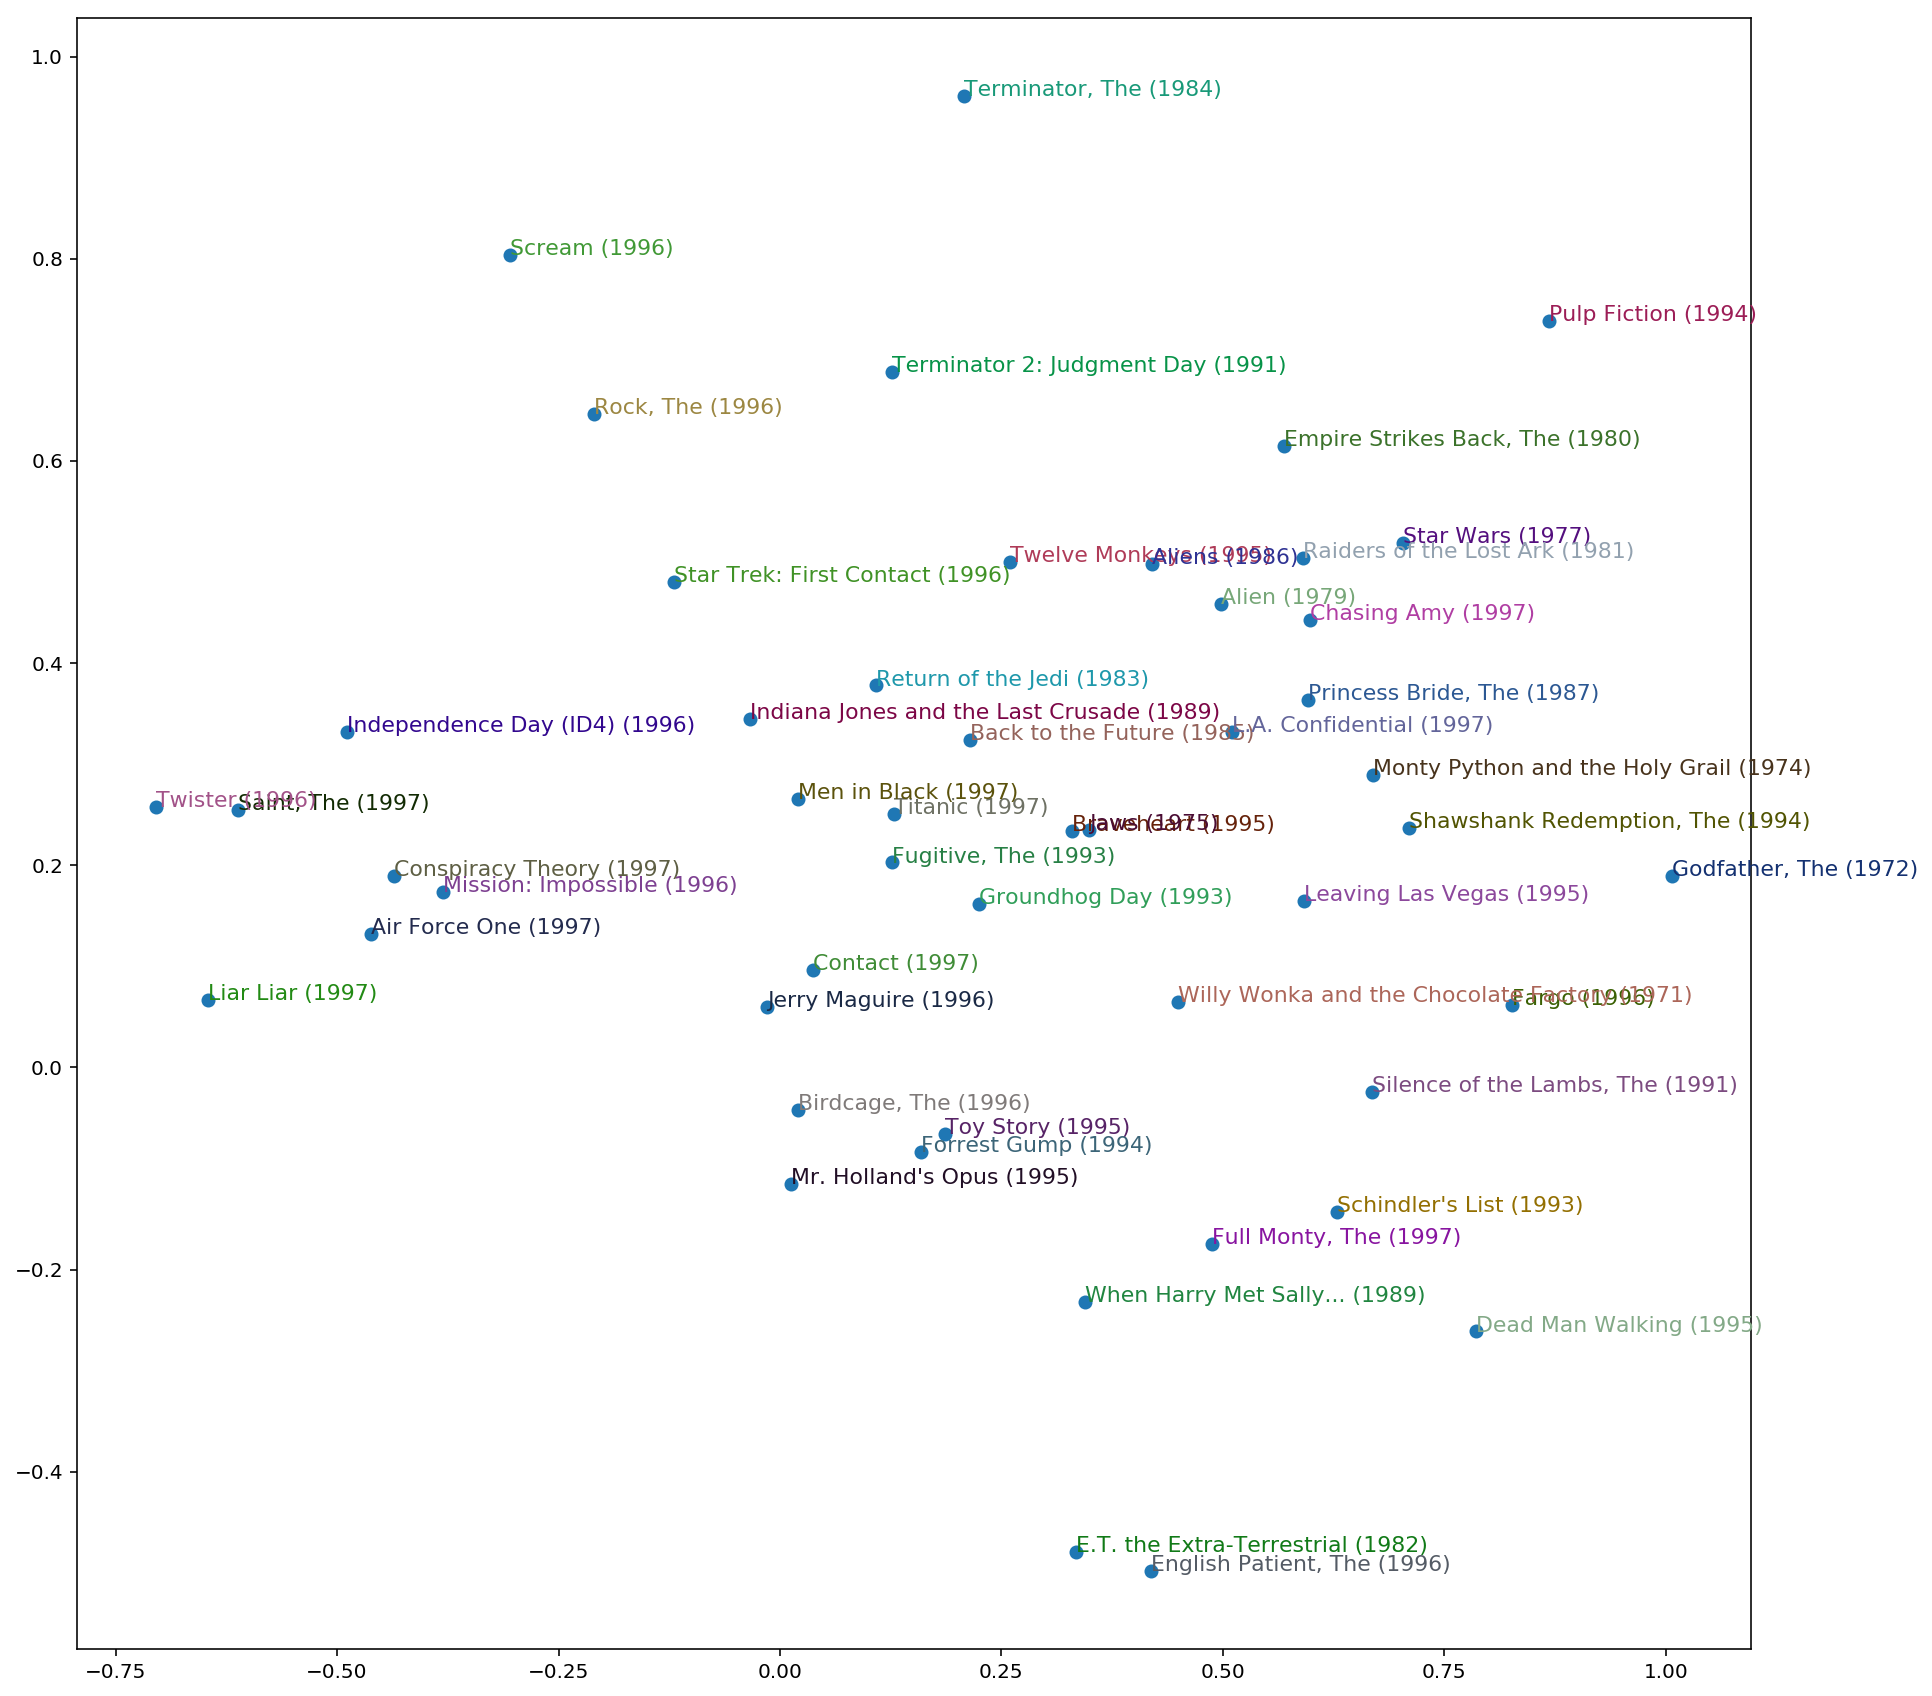

In [70]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show();